# Določanje optimalnega števila stolpcev z uporabo Kullback-Leibler divergence

Imamo set podatkov. Želimo si poiskati optimalno število stolpcev $n$, da ustvarimo histogram z $n$ stolpci.

Najprej navedimo idejo metode. Najprej bomo z metodo "gaussian kernel density estimation" poiskali približek gostote verjetnosti (poimenujmo ta približek $p$). Želimo primerjati ta približek s histogramom z $n$ stolpci s Kullback-Leibler divegenco. Ta divergenca se izračuna po formuli:
$$D_{KL}(p\|h) = \int_{\Omega}p(x)\cdot\log\Big(\frac{p(x)}{h(x)}\Big)\quad dx.$$

Najprej moramo spremeniti histogram v funkcijo. Definirajmo funkcijo, ki histogram pretvori v funkcijo ene spremenljivke.

In [1]:
def hist_to_fun(histogram):
    # histogram: nabor oblike (heights, edges) - stolpci in meje stolpcev histograma
    # RETURN: funkcija, ki ustreza argumentu histogram
    
    def nested(x, hist):
        [heights, edges] = hist
        # kjer ima histogram vrednost 0, mu bomo zaradi racunanja v nadaljevanju priredili vrednost eps
        h_val = np.finfo(float).eps
        for i in range(len(edges)-1):
            if (edges[i] <= x <= edges[i+1]):
                if heights[i] != 0:
                    h_val = heights[i]
                break
        return h_val
    fun = lambda x: nested(x, histogram)
    return fun

Preverimo, da ta funkcija res ustreza histogramu.

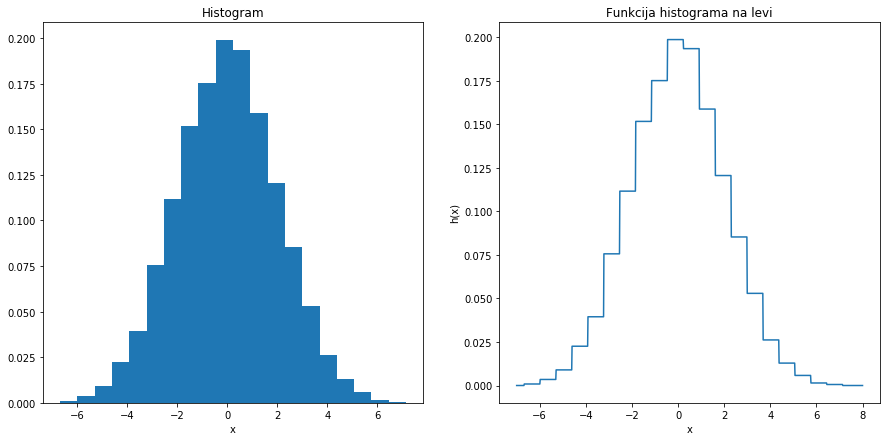

In [3]:
import random
import matplotlib.pyplot as plt
import numpy as np

random.seed(0)

gauss_data = []
for i in range(10000):
    gauss_data.append(random.gauss(0,2))
    
    
plt.figure(figsize=(15, 7))  

plt.subplot(121)
plt.title("Histogram")
y,x,_ = plt.hist(gauss_data, bins=20, density=1)
plt.xlabel("x")

h = hist_to_fun((y,x))

plt.subplot(122)
plt.title("Funkcija histograma na levi")
t = np.linspace(int(min(gauss_data))-1, int(max(gauss_data))+1, 1000)
h_t = [h(el) for el in t]
plt.plot(t, h_t)
plt.xlabel("x")
plt.ylabel("h(x)")

plt.show()

Definirajmo še Kullback-Leiblerjevo divergenco, ki smo jo definirali zgoraj.

In [3]:
from math import log
# integrate_num je Riemanova integracija (hitreje kot scipy.integrate.quad)
from manual_integration import integrate_num
from scipy import integrate

def KL_divergence(p, q, a, b):
    # p: prva gostota verjetnosti
    # q: druga gostota verjetnosti
    # a, b: meji intervala [a,b], na katerem bomo integrirali
    
    # integrand
    def integrand(x):
        return p(x)*log(p(x)/q(x))
    
    return integrate.quad(integrand, a, b)[0]

Naredimo iteracijo po stevilu stolpcev $n$. Za set podatkov vzemimo <tt>gauss_data</tt>, ki smo ga zgenerirali zgoraj. V vsaki iteraciji bomo ustvarili histogram z $n$ stolpci. Nato bomo histogramu priredili ustrezno funkcijo $h$. Setu podtkov <tt>gauss_data</tt> bomo priredili gostoto verjetnosti $p$ z metodo <tt>gaussian_kde</tt>. Nato bomo s Kullback-Leiblerjevo metodo primerjali $p$ in $h$. Kot optimum bomo vzeli minimum te funkcije.

In [4]:
from scipy import stats
import numpy as np

# zacetno stevilo stolpcev
n_z = 10
# do katerega stevila stolpcev gledamo
n_k = 100

# gostota verjetnosti gauss_data glede na gaussian kernel density estimation
p = stats.gaussian_kde(gauss_data)

# meje integriranja
a = min(gauss_data)
b = max(gauss_data)

# seznam, v katerega bomo pripenjali vrednsti KL-divergence
KL_index = []

# iteracija
for n in range(n_z, n_k+1):
    # histogram
    hist = np.histogram(gauss_data, bins=n, density=1)
    #funkcija histograma
    h = hist_to_fun(hist)
    KL_index.append((KL_divergence(p,h,a,b), n))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


Poglejmo si graf KL-divergence v odvisnosti od števila stolpcev histograma $n$. Predpostavimo še, da je za nas sprejemljivo 5% odstopanje, zato si izrišimo še mejo, pod katero so za nas optimalna števila stolpcev.

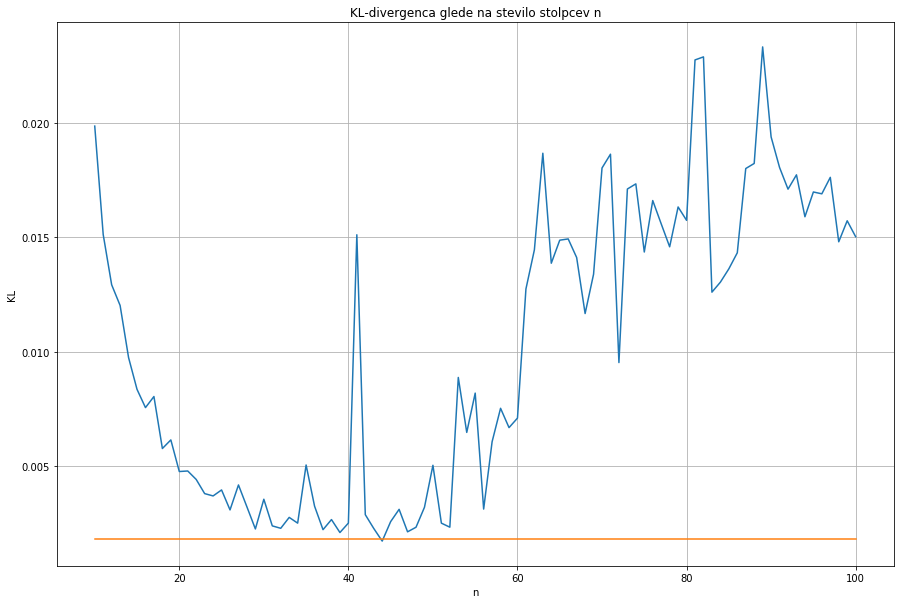

In [5]:
izris_x = np.array(range(n_z, n_k+1))

KL = [kl[0] for kl in KL_index]

# figure
plt.figure(figsize=(15,10))
plt.title("KL-divergenca glede na stevilo stolpcev n")
# graf vrednosti KL-divergence
plt.plot(izris_x, KL)
plt.xlabel("n")
plt.ylabel("KL")

# sprejemljiva napaka - 5%
a = 1.05*min(KL)
y = [a for x in izris_x]

plt.plot(izris_x, y)
plt.grid()
plt.show()

Poglejmo, za kaktere $n$ je KL-divergenca pod našo mejo.

In [6]:
optimalBinNumber = []

for i in range(len(KL_index)):
    if KL_index[i][0] < a:
        optimalBinNumber.append(KL_index[i][1])

print(optimalBinNumber)

[44]


Primerjajmo to število stolpcev z optimalnim številom stolpcev, izračunanih po ostalih metodah za določanje optimalnega števila stolpcev. Za primerjavo vzemimo kar tisto število stolpcev, pri kateremu je KL-divergenca najmanjša.

In [7]:
index_of_minimum = KL_index[KL.index(min(KL))][1]
print(index_of_minimum)

44


In [8]:
from optimalBinNumber import optBinNum
print("Method: value\n")
print("Square-root: ", optBinNum(gauss_data, "sqrt"))
print("Scott: ", optBinNum(gauss_data, "scott"))
print("Rice: ", optBinNum(gauss_data, "rice"))
print("Sturges: ", optBinNum(gauss_data, "sturges"))
print("Freedman-Diaconis: ", optBinNum(gauss_data, "fd"))
print("Doane: ", optBinNum(gauss_data, "doane"))
print("\nKL-metoda: ", index_of_minimum)

Method: value

Square-root:  100
Scoot:  43
Rice:  44
Sturges:  15
Freedman-Diaconis:  55
Doane:  20

KL-metoda:  44


KL metodo bomo implementirali v funkcijo <tt>optBinNum</tt> iz modula <tt>optimalBinNum</tt>.

# Testiranje metode na drugih porazdelitvah

Testirajmo zdaj še KL metodo za določanje optimalnega števila stolpcev še na drugih porazdelitvah. Definirajmo funkcijo, s katero bomo testirali optimalno število stolpcev in primerjali rezultat z ostalimi metodami.

In [9]:
from optimalBinNumber import optBinNum

def test(data):
    a = optBinNum(data, "sqrt")
    b = optBinNum(data, "scott")
    c = optBinNum(data, "rice")
    d = optBinNum(data, "sturges")
    e = optBinNum(data, "fd")
    f = optBinNum(data, "doane")
    print("Method: value\n")
    print("Square-root: ", a)
    print("Scott: ", b)
    print("Rice: ", c)
    print("Sturges: ", d)
    print("Freedman-Diaconis: ", e)
    print("Doane: ", f)
    print("")
    # kl metoda integrira s funkcijo scipy.integrate.quad
    g = optBinNum(data, "kl", n_k=100)
    print("KL-metoda: ", g)
    return [a,b,c,d,e,f,g]

## Porazdelitev gaussovskih mešanic

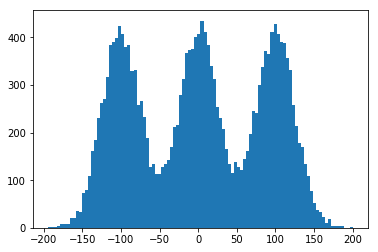

In [10]:
from GMM import GMM
import matplotlib.pyplot as plt

gmm = GMM([[-100,5],[0,5],[100,5]], 20000)

plt.hist(gmm,100)
plt.show()

In [11]:
binnum = test(gmm)

Method: value

Square-root:  142
Scoot:  36
Rice:  55
Sturges:  16
Freedman-Diaconis:  33
Doane:  21

iskanje od 10 do 100:
10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,

KL-metoda:  39


Izrišimo sedaj histograme s številom stolpcev, ki smo jih dobili po zgornjih metodah.

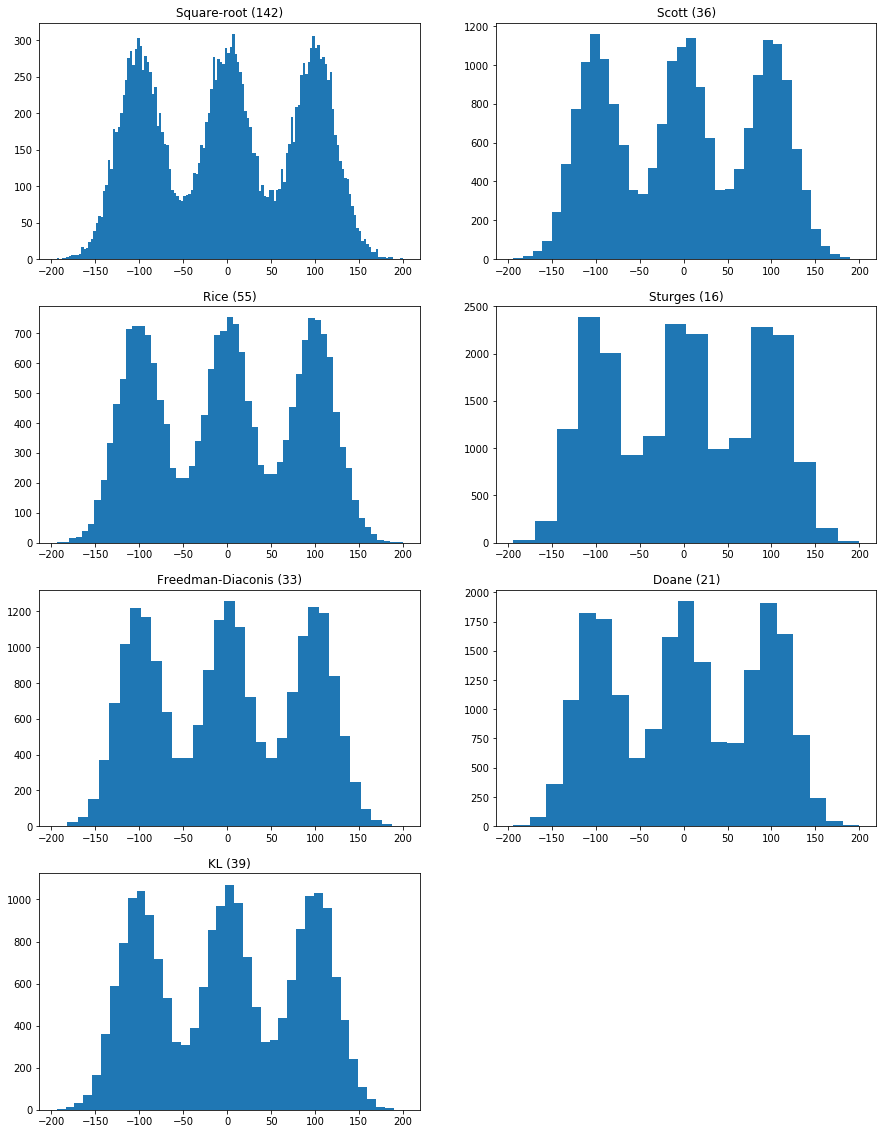

In [12]:
[a,b,c,d,e,f,g] = binnum

plt.figure(figsize=(15,20))

plt.subplot(421)
plt.title("Square-root ({})".format(a))
plt.hist(gmm,bins=a)

plt.subplot(422)
plt.title("Scott ({})".format(b))
plt.hist(gmm,bins=b)

plt.subplot(423)
plt.title("Rice ({})".format(c))
plt.hist(gmm,bins=c)

plt.subplot(424)
plt.title("Sturges ({})".format(d))
plt.hist(gmm,bins=d)

plt.subplot(425)
plt.title("Freedman-Diaconis ({})".format(e))
plt.hist(gmm,bins=e)

plt.subplot(426)
plt.title("Doane ({})".format(f))
plt.hist(gmm,bins=f)

plt.subplot(427)
plt.title("KL ({})".format(g))
plt.hist(gmm,bins=g)

plt.show()

Metoda sicer deluje, vendar je zelo počasna. Poglejmo, koliko časa traja.

In [13]:
import time
zac = time.time()
optBinNum(gmm,"kl",n_k=100)
kon = time.time()

iskanje od 10 do 100:
10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,



In [14]:
print("Da se metoda izvede od 5 do 100 stolpcev traja: " + str(round(kon-zac,2))+" sekund")

Da se metoda izvede od 5 do 100 stolpcev traja: 131.22 sekund


## Normalna porazdelitev s podatki v repu

Zanima nas, kako se metode obnesejo na posebnih porazdelitvah. Zgenerirajmo gaussovo porazdelitev, ki ima nekaj podatkov tudi v repu

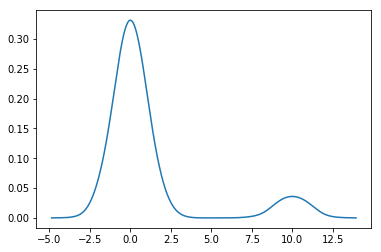

In [15]:
from GMM import GMM
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

normRep = GMM([[0,1],[10,1]], 10000, [0.9,0.1])

pdf = gaussian_kde(normRep)

x = np.linspace(min(normRep)-1, max(normRep)+1, 10000)

plt.plot(x, pdf(x))
plt.show()

In [16]:
binnum = test(normRep)

Method: value

Square-root:  100
Scoot:  33
Rice:  44
Sturges:  15
Freedman-Diaconis:  122
Doane:  21

iskanje od 10 do 100:
10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,

KL-metoda:  51


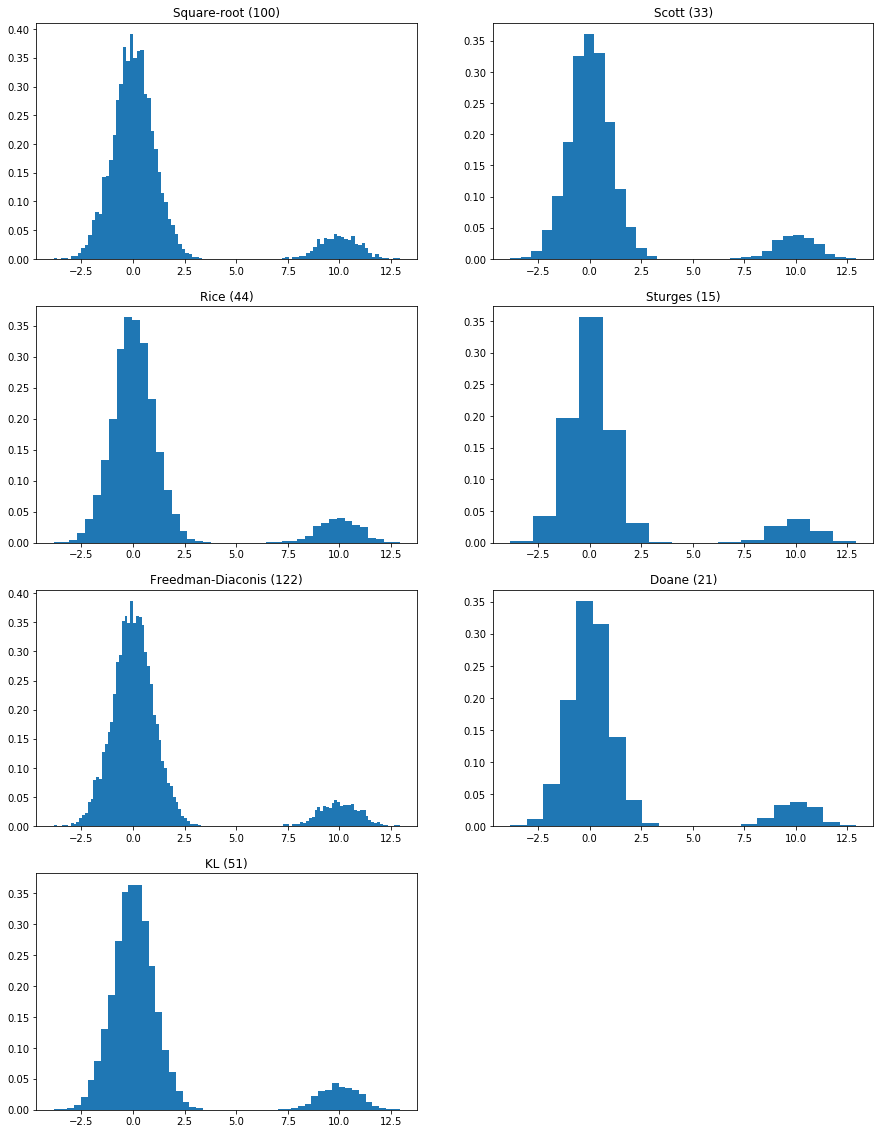

In [17]:
[a,b,c,d,e,f,g] = binnum
toHist = normRep

plt.figure(figsize=(15,20))

plt.subplot(421)
plt.title("Square-root ({})".format(a))
plt.hist(toHist,bins=a,density=1)

plt.subplot(422)
plt.title("Scott ({})".format(b))
plt.hist(toHist,bins=b,density=1)

plt.subplot(423)
plt.title("Rice ({})".format(c))
plt.hist(toHist,bins=c,density=1)

plt.subplot(424)
plt.title("Sturges ({})".format(d))
plt.hist(toHist,bins=d,density=1)

plt.subplot(425)
plt.title("Freedman-Diaconis ({})".format(e))
plt.hist(toHist,bins=e,density=1)

plt.subplot(426)
plt.title("Doane ({})".format(f))
plt.hist(toHist,bins=f,density=1)

plt.subplot(427)
plt.title("KL ({})".format(g))
plt.hist(toHist,bins=g,density=1)

plt.show()

Vzemimo porazdelitev še z manj podatki v repu.

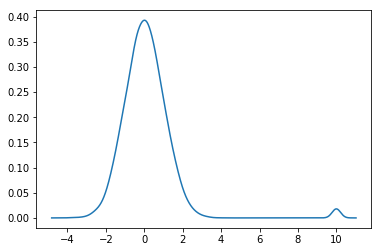

In [18]:
from GMM import GMM
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

normRep1 = GMM([[0,1],[10,0.1]], 10000, [0.99,0.01])

pdf = gaussian_kde(normRep1)

x = np.linspace(min(normRep1)-1, max(normRep1)+1, 10000)
plt.plot(x, pdf(x))
plt.show()

In [19]:
binnum1 = test(normRep1)

Method: value

Square-root:  100
Scoot:  61
Rice:  44
Sturges:  15
Freedman-Diaconis:  111
Doane:  22

iskanje od 10 do 100:
10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,

KL-metoda:  27


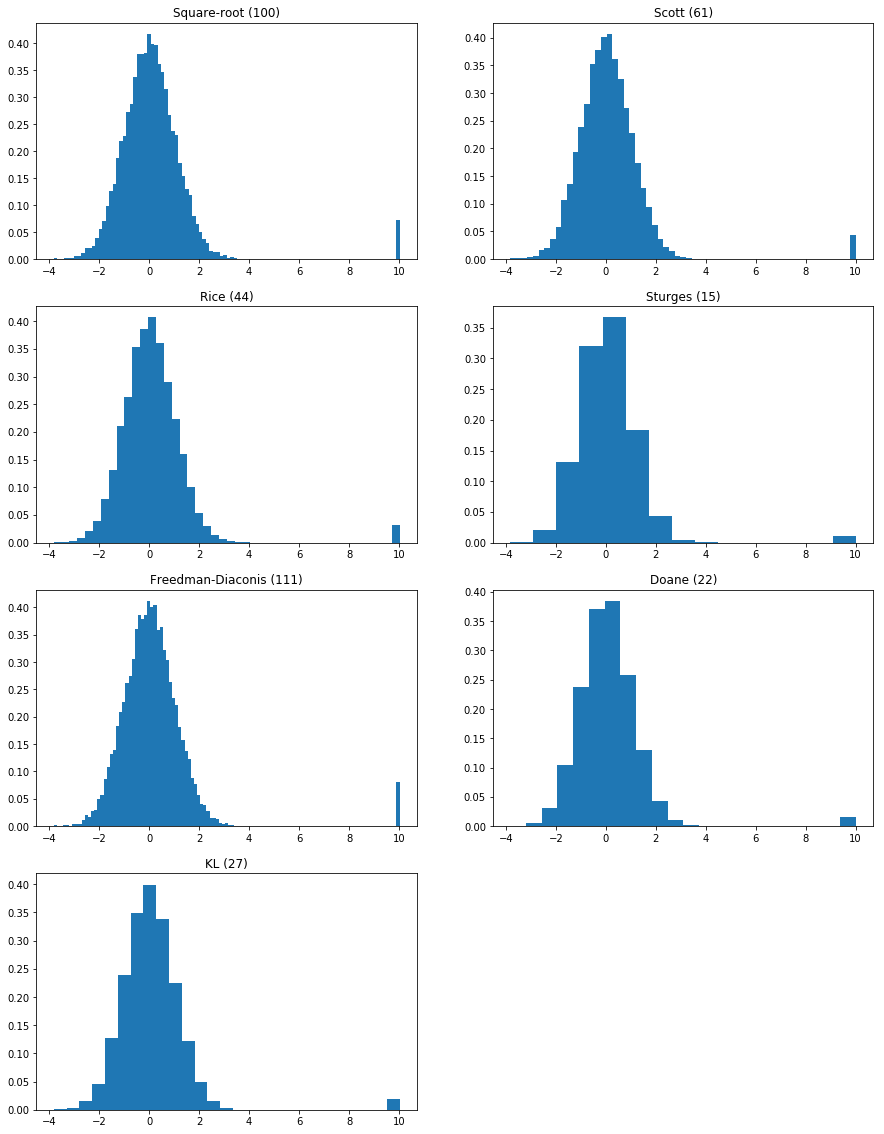

In [20]:
[a,b,c,d,e,f,g] = binnum1
toHist = normRep1

plt.figure(figsize=(15,20))

plt.subplot(421)
plt.title("Square-root ({})".format(a))
plt.hist(toHist,bins=a,density=1)

plt.subplot(422)
plt.title("Scott ({})".format(b))
plt.hist(toHist,bins=b,density=1)

plt.subplot(423)
plt.title("Rice ({})".format(c))
plt.hist(toHist,bins=c,density=1)

plt.subplot(424)
plt.title("Sturges ({})".format(d))
plt.hist(toHist,bins=d,density=1)

plt.subplot(425)
plt.title("Freedman-Diaconis ({})".format(e))
plt.hist(toHist,bins=e,density=1)

plt.subplot(426)
plt.title("Doane ({})".format(f))
plt.hist(toHist,bins=f,density=1)

plt.subplot(427)
plt.title("KL ({})".format(g))
plt.hist(toHist,bins=g,density=1)

plt.show()

Stopnjujemo še naprej:

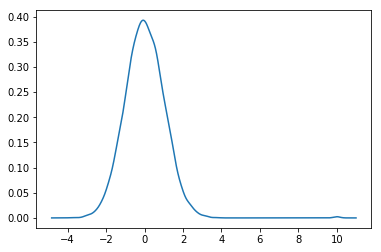

In [21]:
from GMM import GMM
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

normRep2 = GMM([[0,1],[10,0.01]], 10000, [0.999,0.001])

pdf = gaussian_kde(normRep2)

x = np.linspace(min(normRep2)-1, max(normRep2)+1, 10000)
plt.plot(x, pdf(x))
plt.show()

In [22]:
binnum2 = test(normRep2)

Method: value

Square-root:  100
Scoot:  82
Rice:  44
Sturges:  15
Freedman-Diaconis:  111
Doane:  22

iskanje od 10 do 100:
10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,

KL-metoda:  53


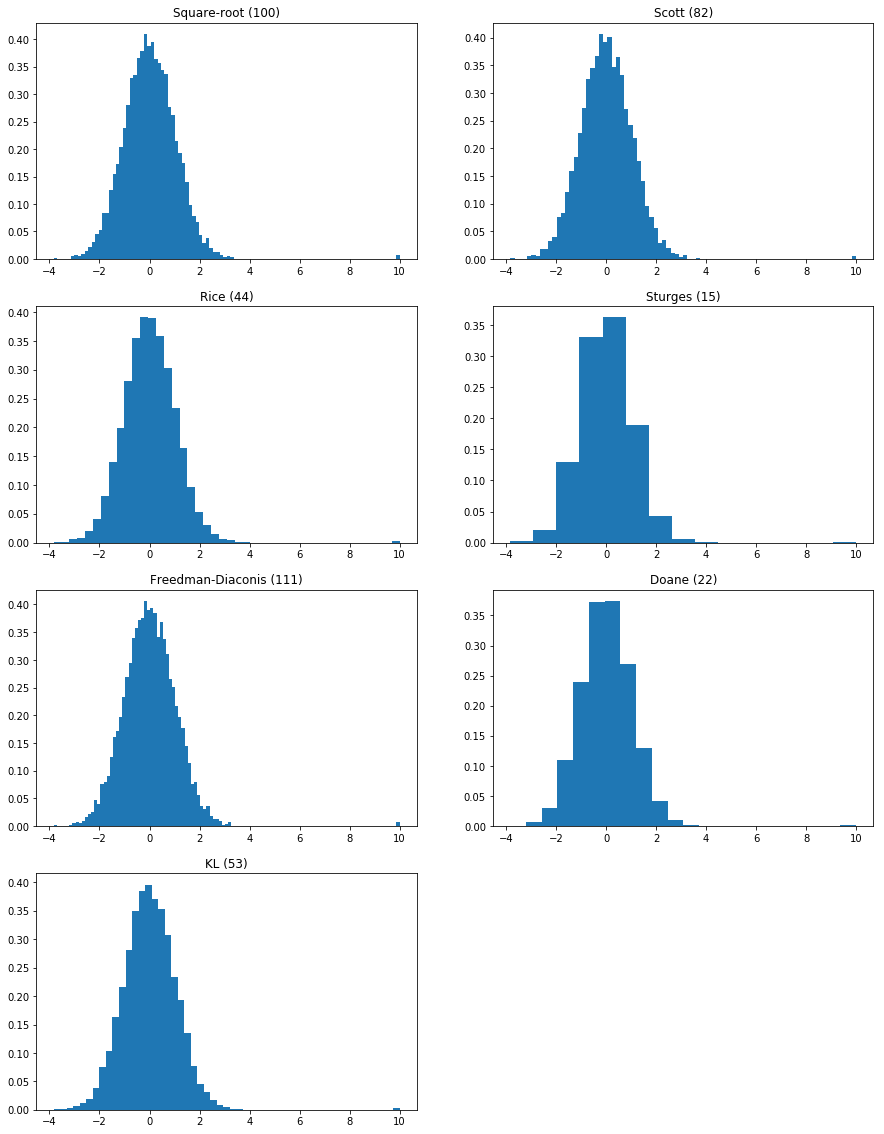

In [23]:
[a,b,c,d,e,f,g] = binnum2
toHist = normRep2

plt.figure(figsize=(15,20))

plt.subplot(421)
plt.title("Square-root ({})".format(a))
plt.hist(toHist,bins=a,density=1)

plt.subplot(422)
plt.title("Scott ({})".format(b))
plt.hist(toHist,bins=b,density=1)

plt.subplot(423)
plt.title("Rice ({})".format(c))
plt.hist(toHist,bins=c,density=1)

plt.subplot(424)
plt.title("Sturges ({})".format(d))
plt.hist(toHist,bins=d,density=1)

plt.subplot(425)
plt.title("Freedman-Diaconis ({})".format(e))
plt.hist(toHist,bins=e,density=1)

plt.subplot(426)
plt.title("Doane ({})".format(f))
plt.hist(toHist,bins=f,density=1)

plt.subplot(427)
plt.title("KL ({})".format(g))
plt.hist(toHist,bins=g,density=1)

plt.show()

Ugotovitev: tudi, ko je v repu zelo malo podatkov, metoda KL deluje. Glede na slike, je to tudi optimalno število stolpcev.